# Importing Libraries

In [457]:
# Main Libraries
import pandas as pd
import numpy as np
import h5py
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os

# Preprocessing
from scipy.signal import welch, butter, filtfilt

# Artifact Rejection
from sklearn.decomposition import FastICA
import pywt

# Feature Extraction
from scipy.fft import fft
from mne.decoding import CSP
from scipy.stats import skew, kurtosis

# Classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [322]:
features_DF_all = pd.DataFrame()

# Load and Visualize Dataset

In [40]:
# Data Files
# Subject 1
# Training 1
r"C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\Previous Data\ssvep\ssvep\subject_1_fvep_led_training_1.mat"
# Training 2
r"C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\Previous Data\ssvep\ssvep\subject_1_fvep_led_training_2.mat"

# Subject 2
# Training 1
r"C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\Previous Data\ssvep\ssvep\subject_2_fvep_led_training_1.mat"
# Training 2
r"C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\Previous Data\ssvep\ssvep\subject_2_fvep_led_training_2.mat"

'C:\\Users\\PC\\Desktop\\Second Semester 2025-2026\\BCI Spring School Hackathon 2025\\Previous Data\\ssvep\\ssvep\\subject_2_fvep_led_training_2.mat'

In [478]:
# Loading Matlab file
# Parameters
subjectNum = 1
trainingNum = 2

# Data File Path
eegDataPath = fr'C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\Previous Data\ssvep\ssvep\subject_{subjectNum}_fvep_led_training_{trainingNum}.mat'
classDataPath = r"C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\Previous Data\ssvep\ssvep\classInfo_4_5.m"

with h5py.File(eegDataPath, 'r') as f:
    keys_list = list(f.keys())
    print('Available Keys: ', keys_list)

    # Reading dataset
    datasetKey = keys_list[0]
    eegData = np.array(f[datasetKey])

    # Dataframe
    eegDataDF = pd.DataFrame(eegData)

# EEG channels labels
eeg_channel_labels = ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
column_names = ['Time'] + eeg_channel_labels + ['Trigger', 'LDA_output']
eegDataDF.columns = column_names

# Avoid overwrite
eegDataDFCopy = eegDataDF.copy()


# Loading Class Information
with open(classDataPath, 'r') as fClass:
    lines = fClass.readlines()

# Matrix starting and ending
matrixLines = [line.strip() for line in lines if line.strip().startswith(('0', '1'))]

# Converting to numpy array
matrix = np.array([list(map(int, line.replace(';', '').split())) for line in matrixLines])
frequencies = [9, 10, 12, 15]
labels = [frequencies[np.argmax(row)] for row in matrix]
classesDF = pd.DataFrame(matrix, columns=[f'{f}Hz' for f in frequencies])
classesDF['FrequencyLabels'] = labels

Available Keys:  ['y']


# Visualize Data

## Original Data

In [479]:
# Global font and Times new Roman
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 14
})

array([[<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>]], dtype=object)

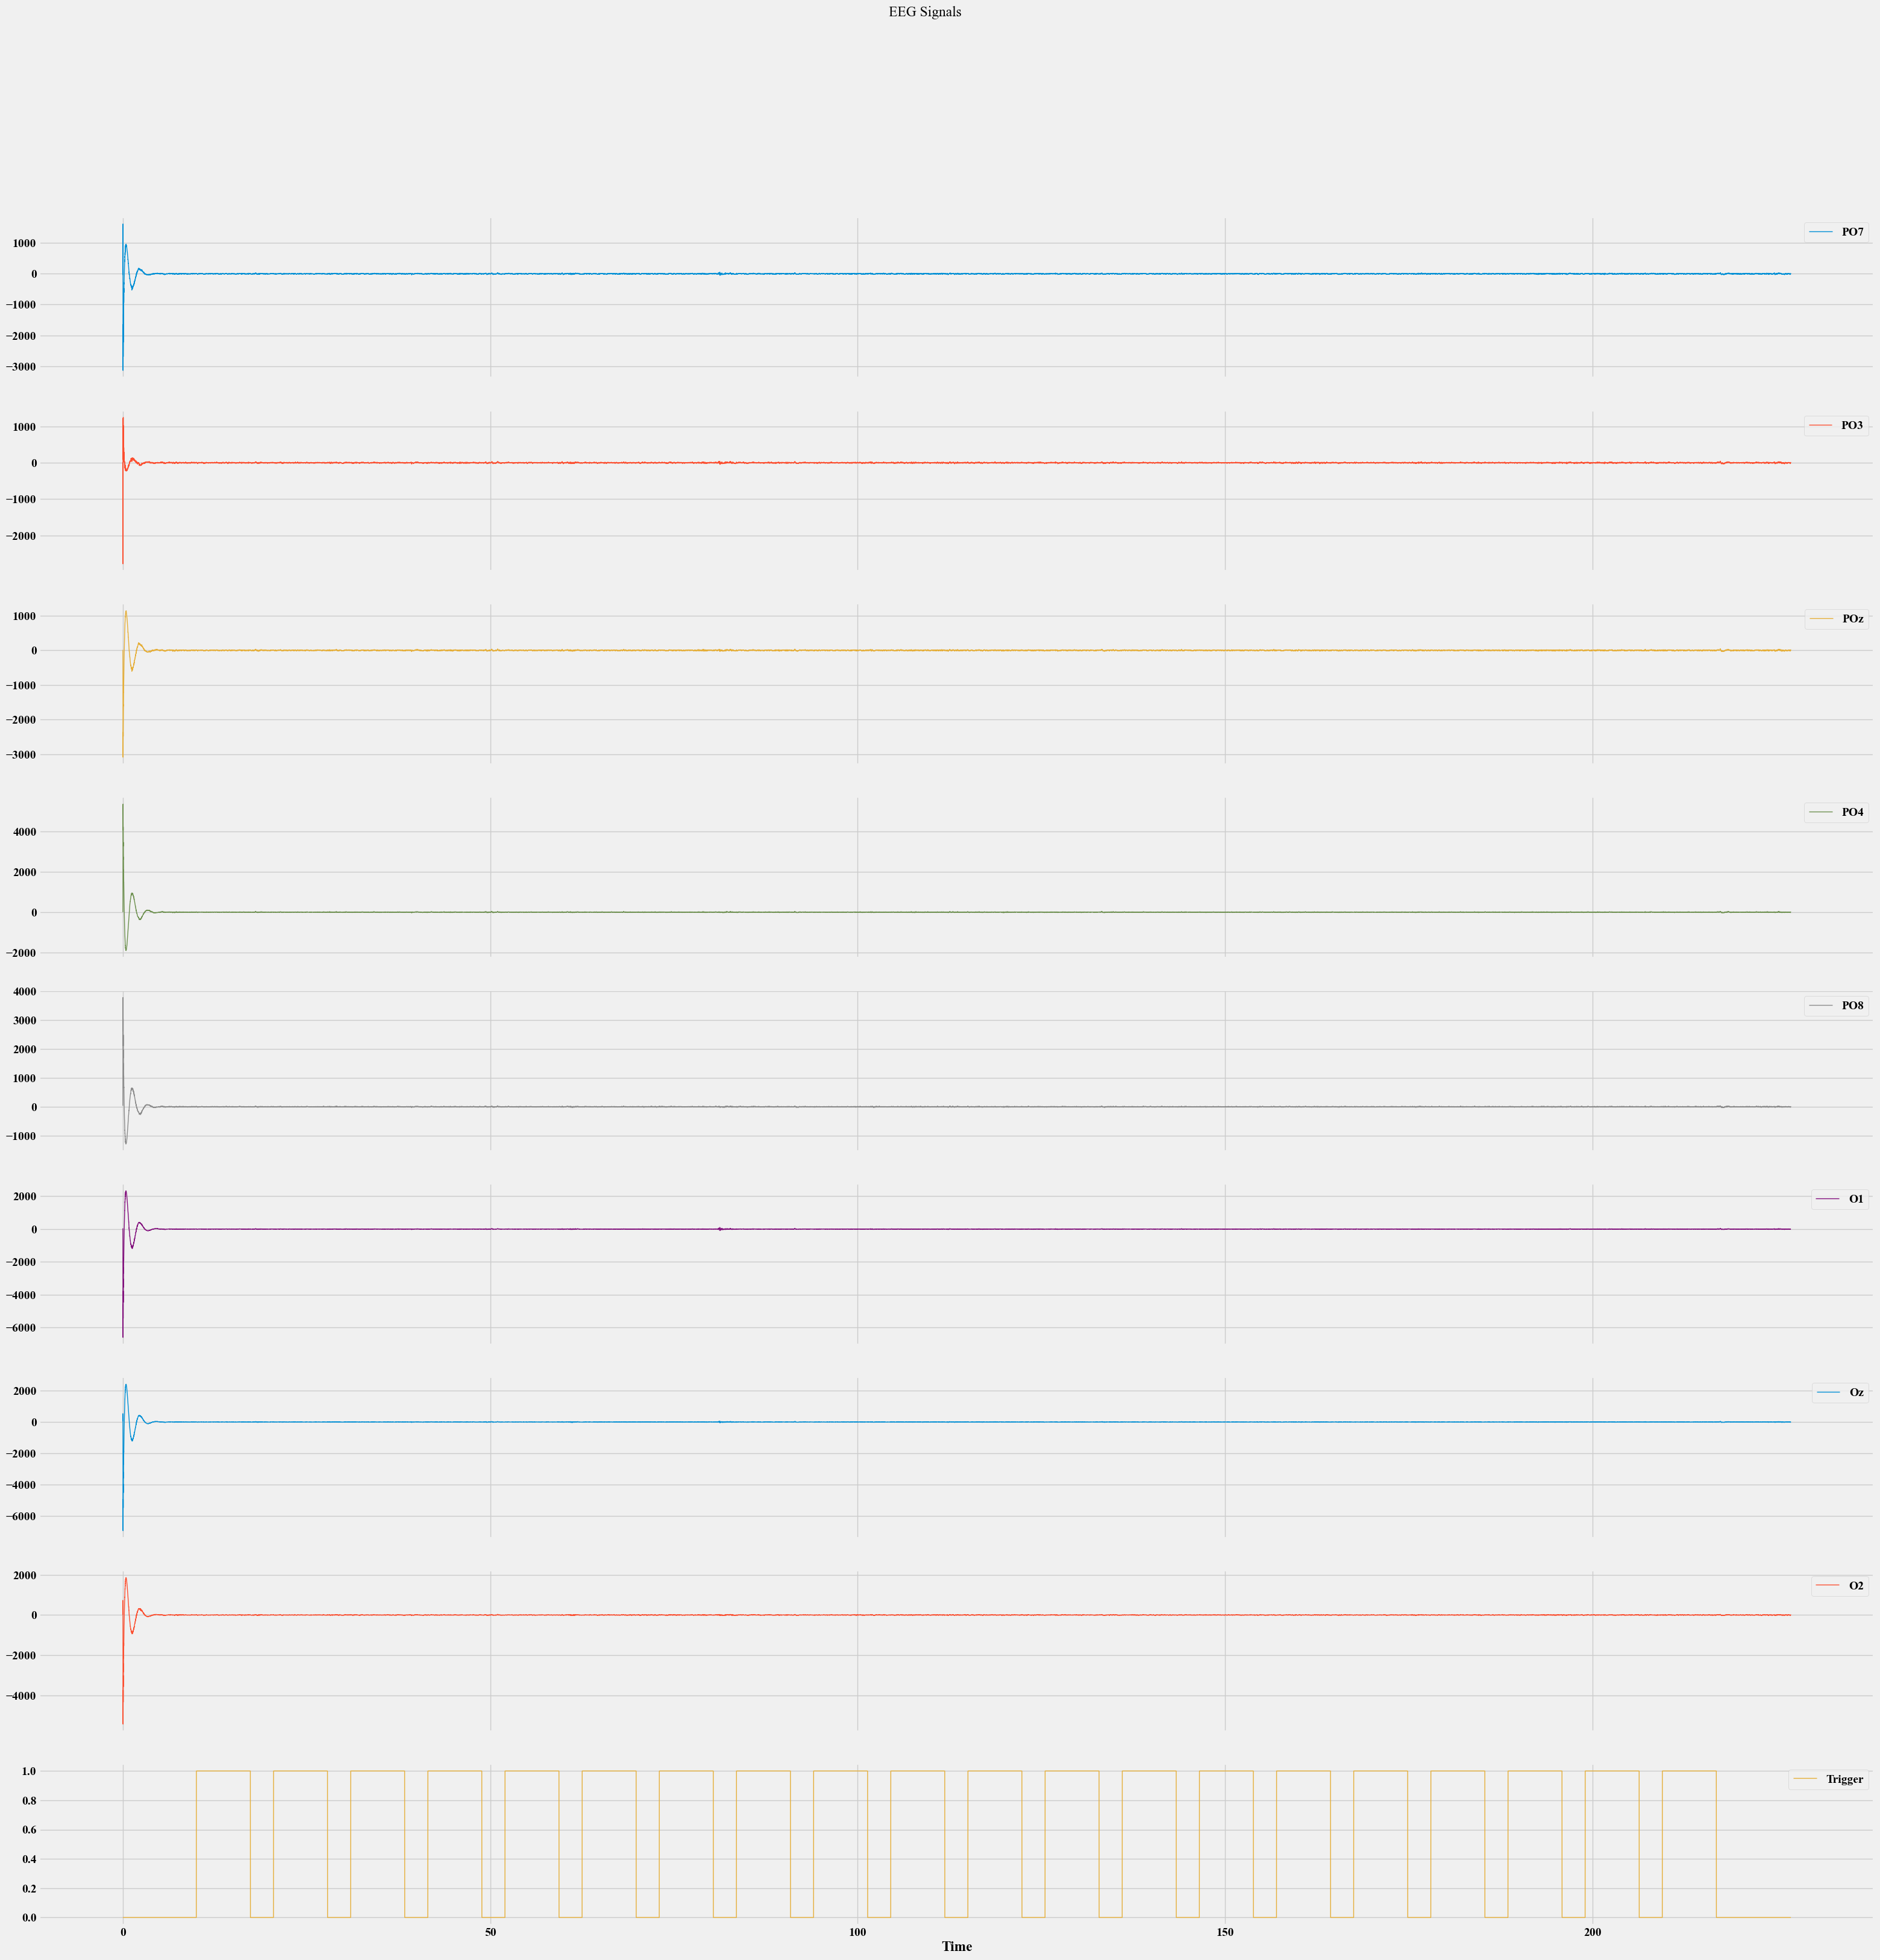

In [480]:
eegDataDFCopy_time = eegDataDFCopy.set_index('Time') #Get the time series
eegDataDFCopy_time.drop(columns='LDA_output', inplace=True)
plt.style.use('fivethirtyeight')
eegDataDFCopy_time.plot(subplots = True,
           layout=(9,1),
           figsize =(35, 35),
           fontsize = 14,
           linewidth = 1,
           sharex = True,
           title = 'EEG Signals')

## Sliced Data

In [481]:
eegTrigger = np.nonzero(eegDataDFCopy_time['Trigger'])[0]
slicedeeg = eegDataDFCopy.iloc[eegTrigger[0]:eegTrigger[len(eegTrigger)-1]]

# Get Time Series
slicedEEGTime = slicedeeg.set_index('Time')
slicedEEGTime.drop(columns='LDA_output', inplace=True)

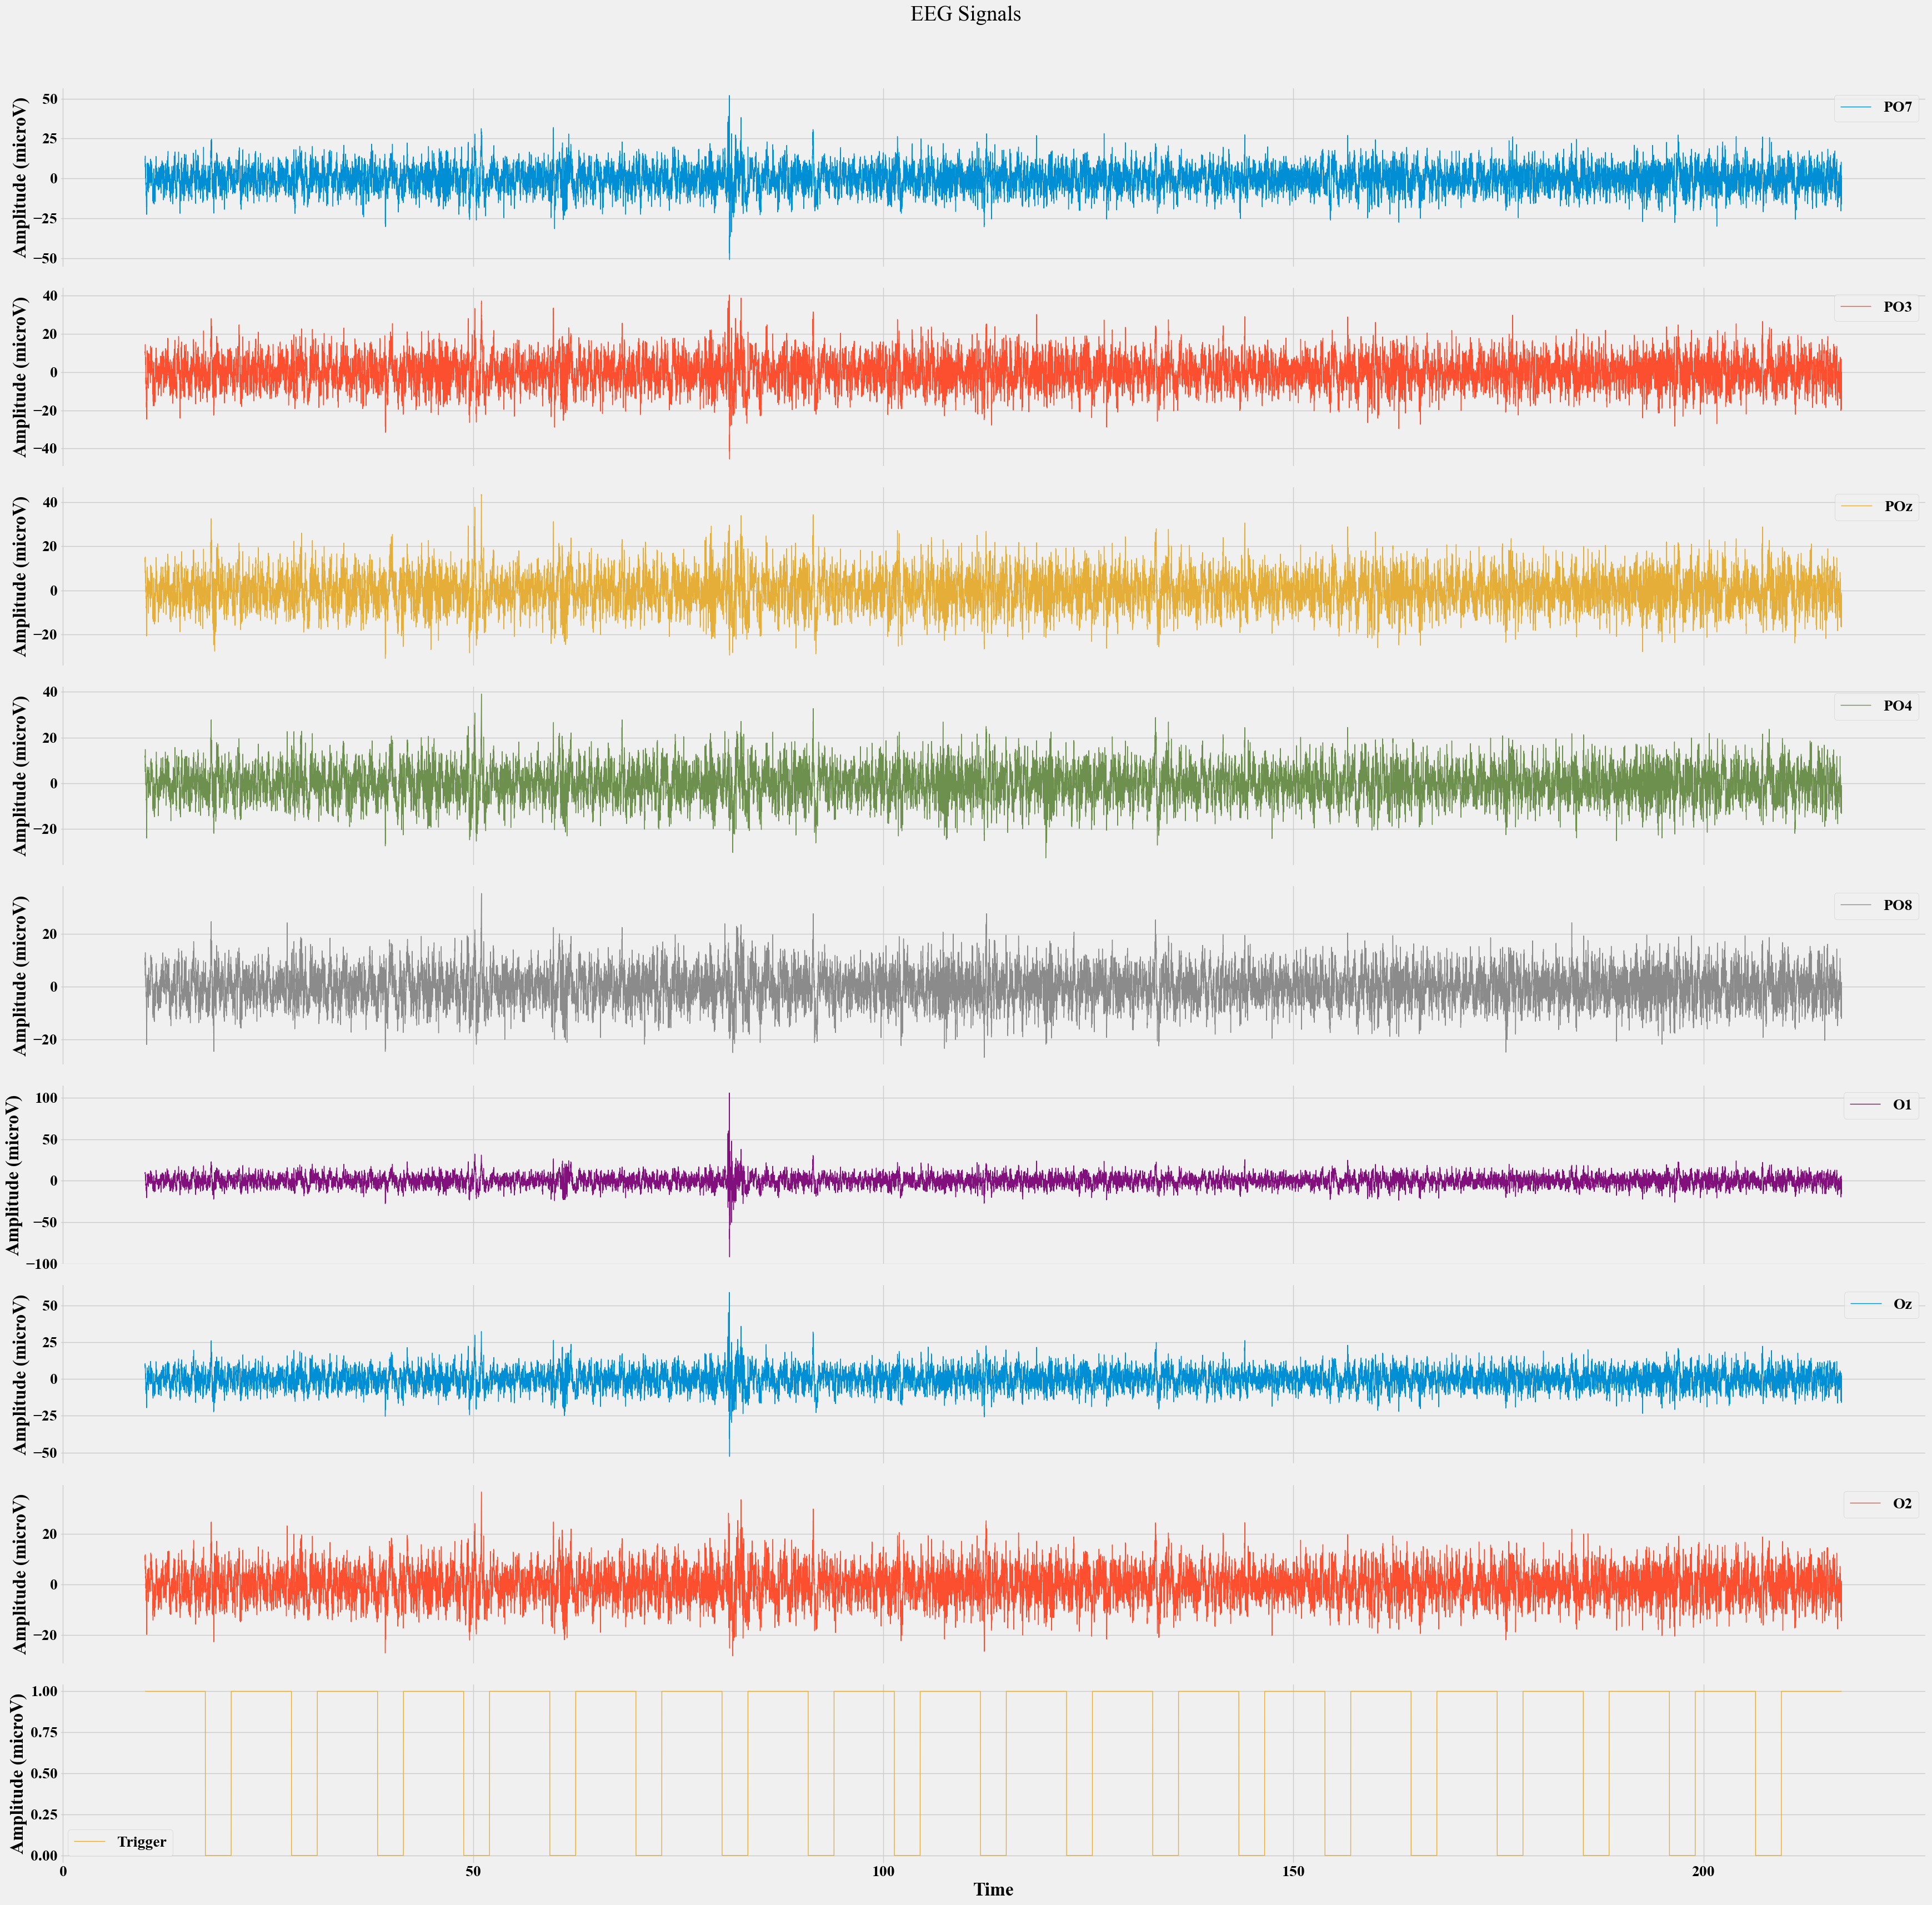

In [482]:
axes = slicedEEGTime.plot(
    subplots=True,
    layout=(9, 1),
    figsize=(35, 35),
    fontsize=14,
    linewidth=1,
    sharex=True,
    title='EEG Signals'
)

# Make title, axis labels, and legends bigger
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=30)      # Bigger subplot titles
    ax.set_xlabel('Time', fontsize=24)            # X-axis label
    ax.set_ylabel('Amplitude (microV)', fontsize=24)       # Y-axis label
    ax.legend(fontsize=20)                        # Legend size
    ax.tick_params(axis='both', which='major', labelsize=20)  # Tick labels size

# Adjust the overall figure title (if you want an overall top title)
plt.suptitle('EEG Signals', fontsize=28)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()

# Power Spectral Density

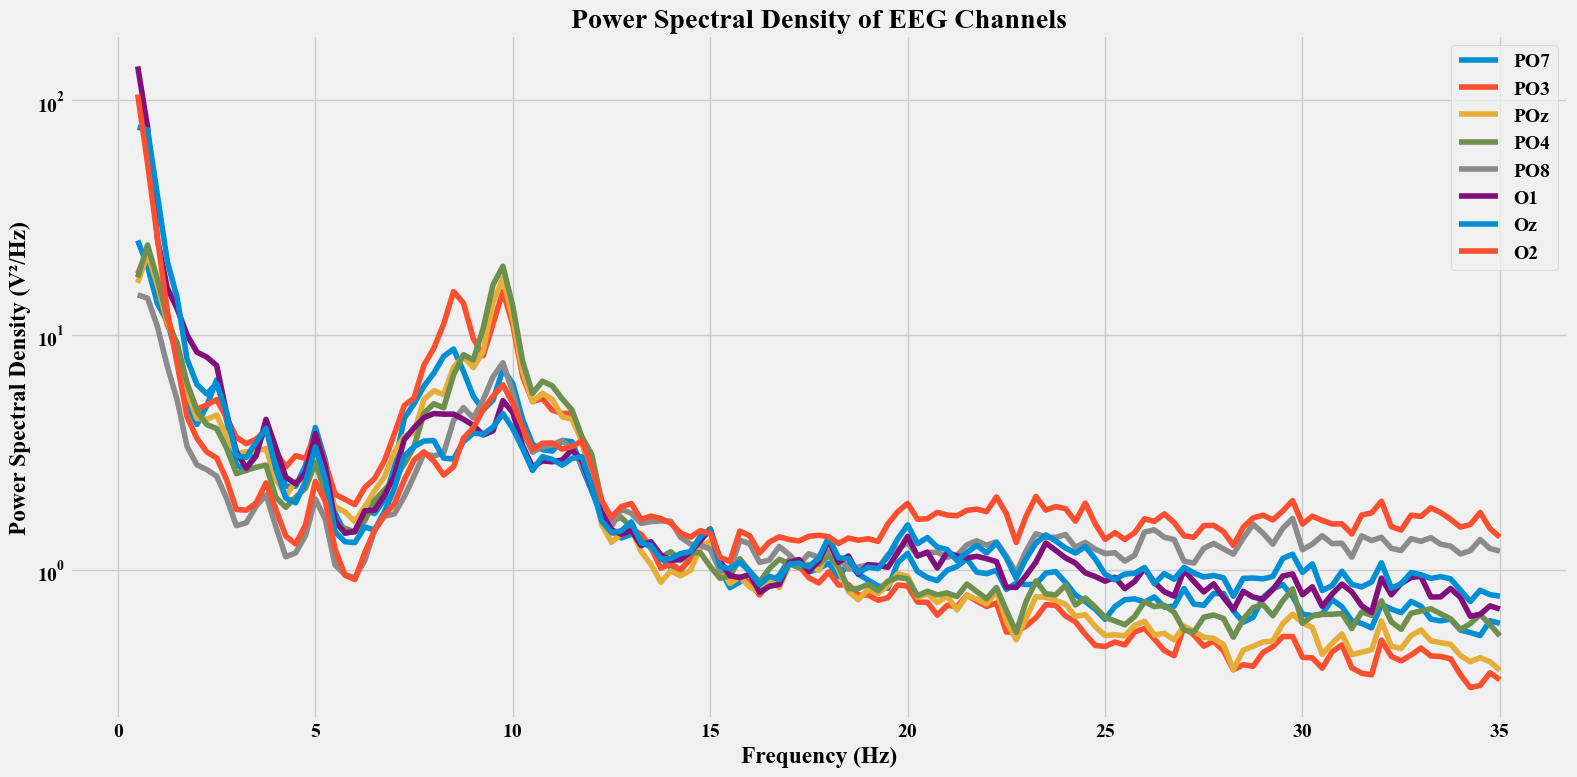

In [430]:
sampling_rate = 256 # Hz 
eegChannels = slicedEEGTime.iloc[:, 0:8] # From PO7 to O2

plt.figure(figsize=(16, 8))

# Power Spectral Density
for ch in eegChannels:
    f, pxx = welch(slicedEEGTime[ch], fs=sampling_rate, nperseg=1024)
    freq_mask = (f >= 0.5) & (f <= 35)
    plt.semilogy(f[freq_mask], pxx[freq_mask], label=ch)

plt.title('Power Spectral Density of EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Artifact Rejection

In [431]:
# Time and Trigger channels
time = slicedeeg['Time']
trigger = slicedEEGTime['Trigger']

## Independent Component Analysis (ICA)

In [432]:
# EEG Data
eegDataICA = slicedEEGTime.iloc[:, :-1]

# ICA
ica = FastICA(n_components=eegDataICA.shape[1], random_state=0)
sources = ica.fit_transform(eegDataICA)
mixing_matrix = ica.mixing_

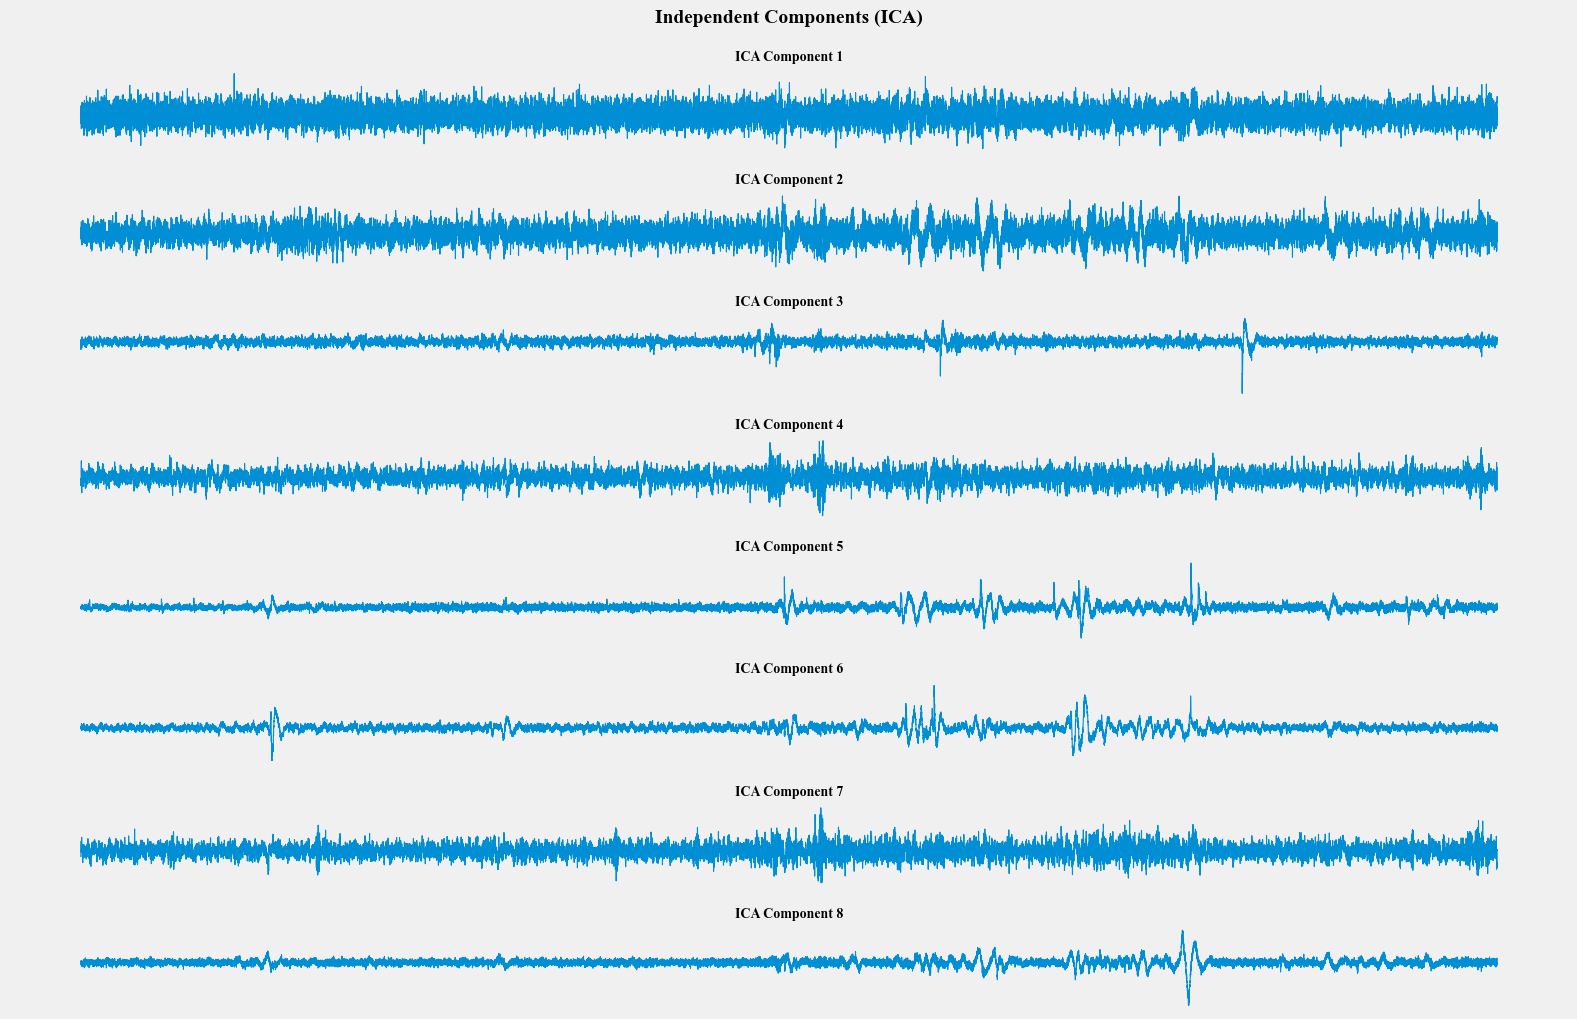

In [433]:
plt.figure(figsize=(16, 10))
for i in range(sources.shape[1]):
    plt.subplot(sources.shape[1], 1, i+1)
    plt.plot(sources[:, i], linewidth=0.8)
    plt.title(f'ICA Component {i+1}', fontsize=10)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.suptitle('Independent Components (ICA)', fontsize=14, fontweight='bold', y=1.02)
plt.show()

In [434]:
artifact_indices = [2] 

# Zero out artifact components
sources_clean = sources.copy()
sources_clean[:, artifact_indices] = 0

In [409]:
eeg_cleaned = np.dot(sources_clean, mixing_matrix.T)

# Create DataFrame with original column names
eegCleanedDF = pd.DataFrame(eeg_cleaned, columns=eegDataICA.columns)
time = time.reset_index(drop=True)
trigger = trigger.reset_index(drop=True)
eegCleanedDF.insert(loc=0, column='Time', value=time)
eegCleanedDF['Trigger'] = trigger

array([[<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>]], dtype=object)

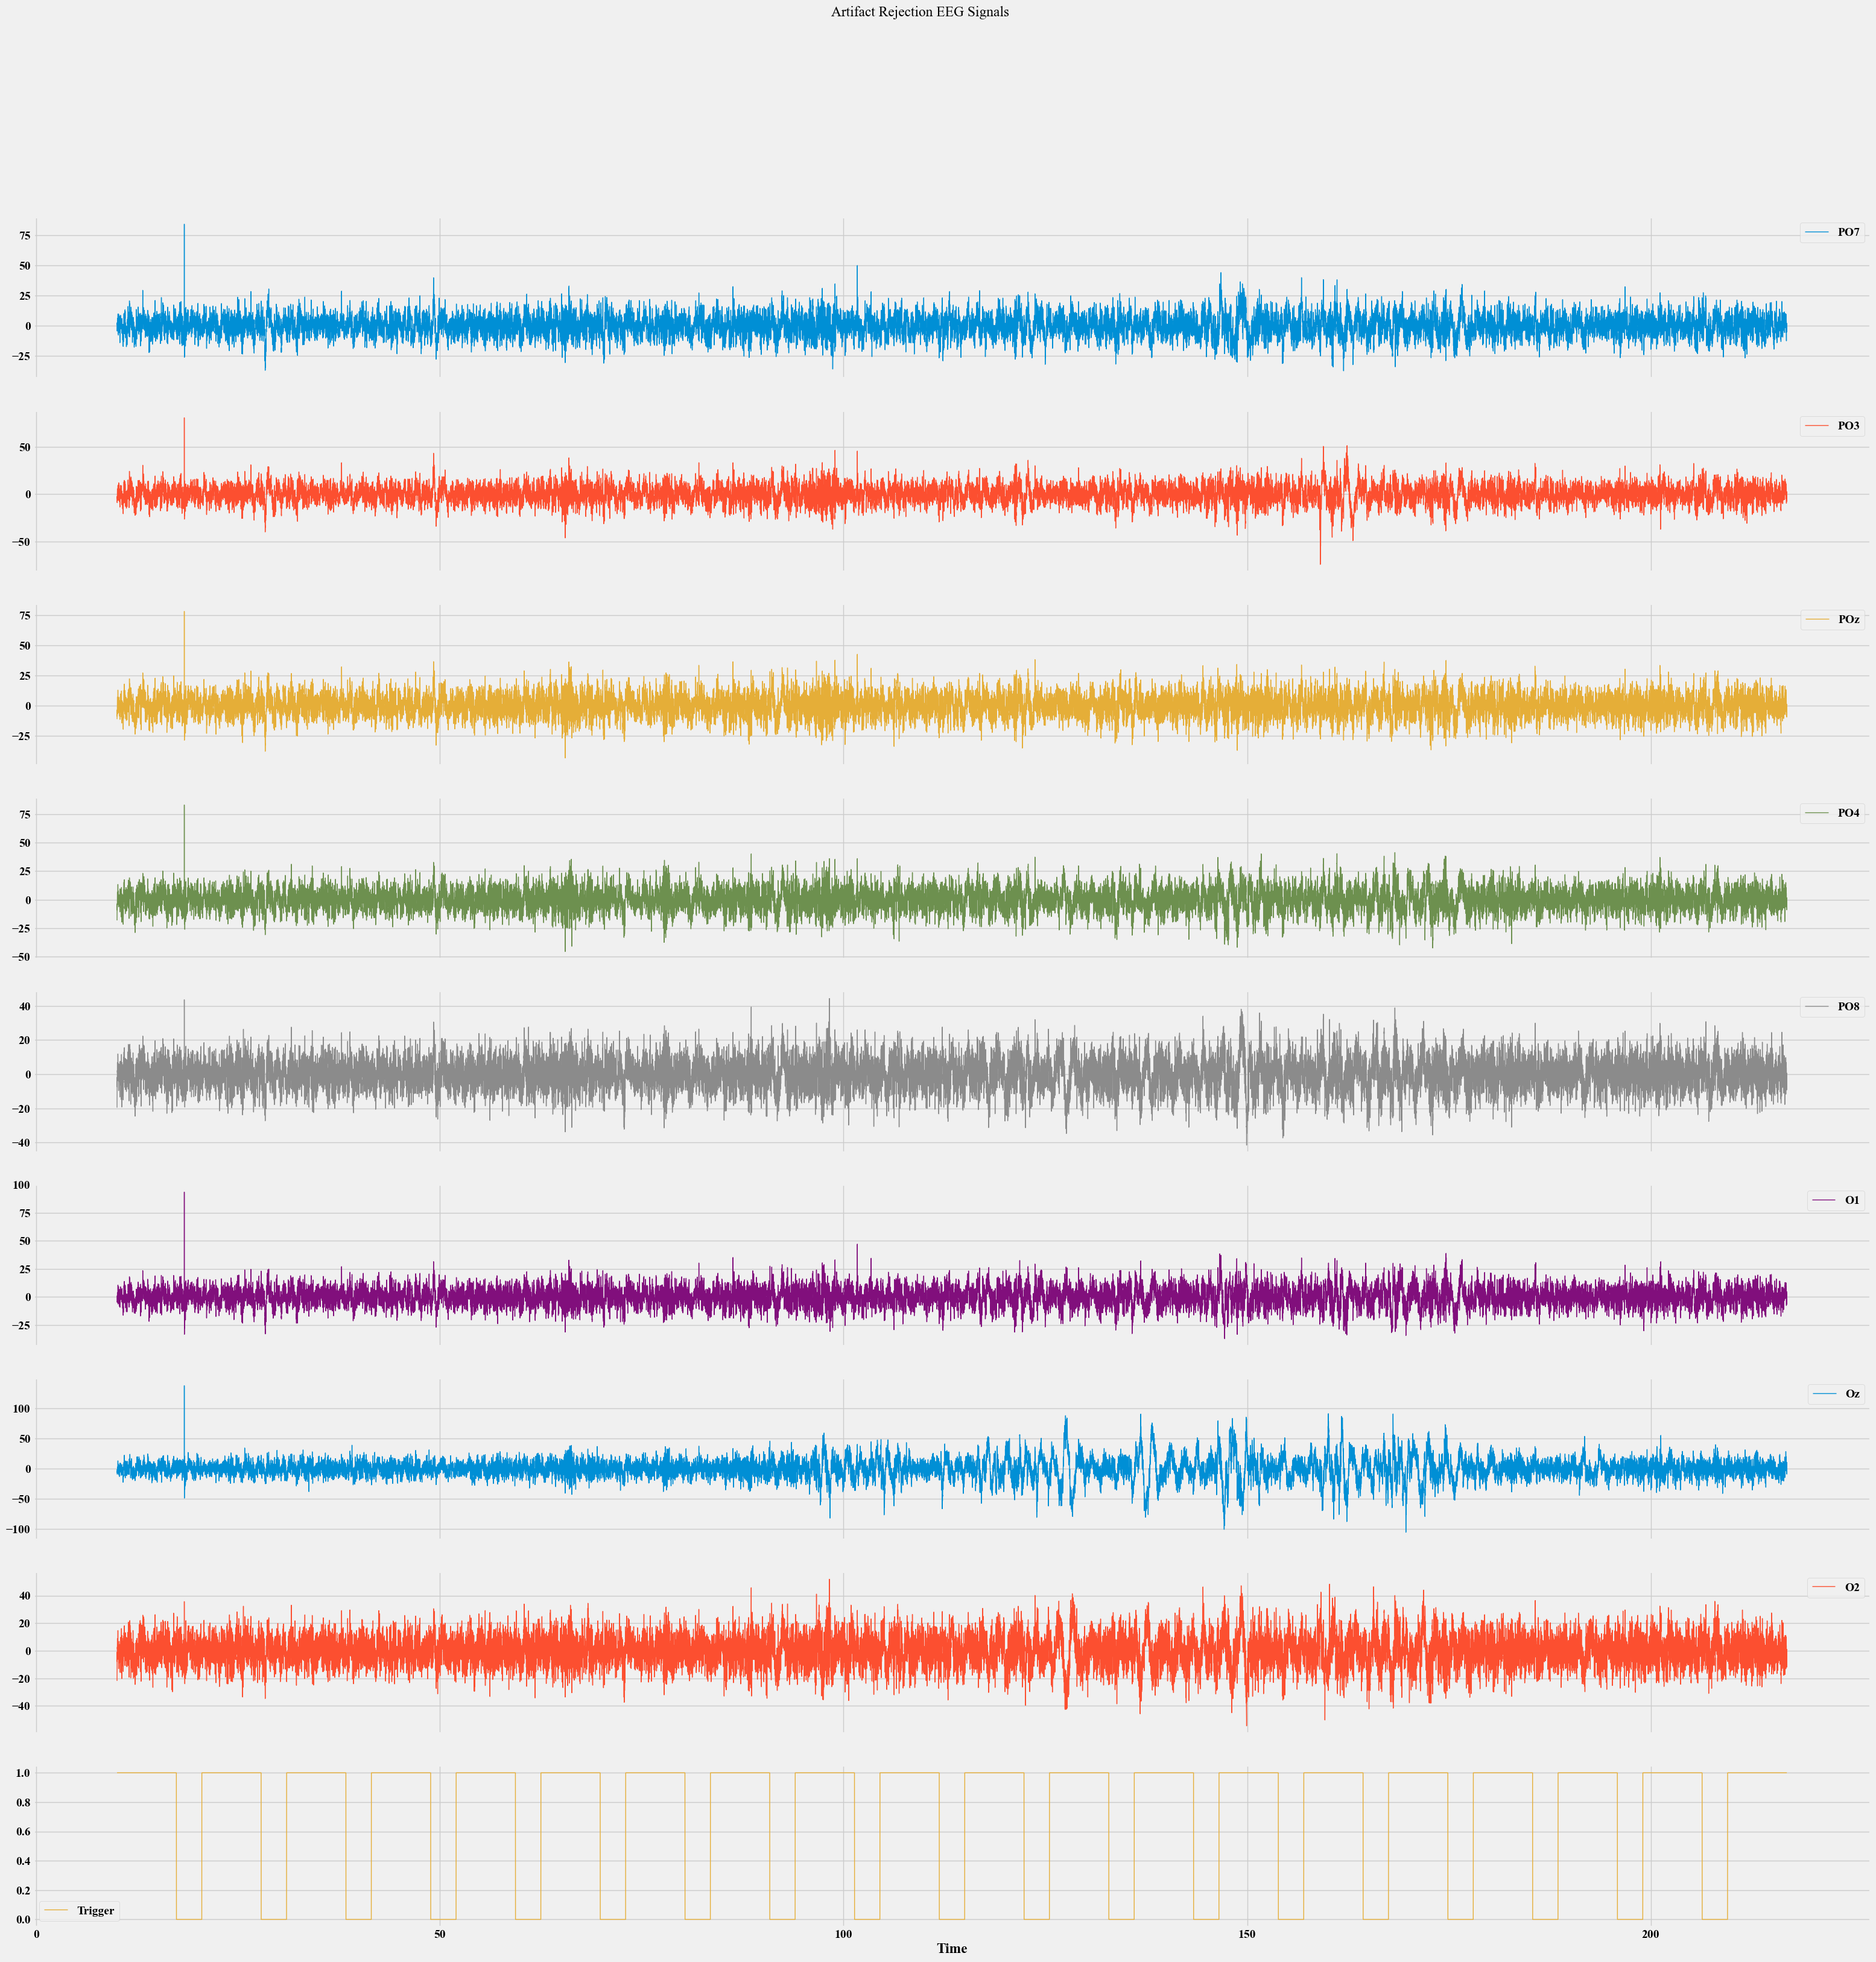

In [435]:
eegCleanedDFTime = eegCleanedDF.set_index('Time')
eegCleanedDFTime.plot(subplots = True,
           layout=(9,1),
           figsize =(35, 35),
           fontsize = 14,
           linewidth = 1,
           sharex = True,
           title = 'Artifact Rejection EEG Signals')

<Figure size 1600x800 with 0 Axes>

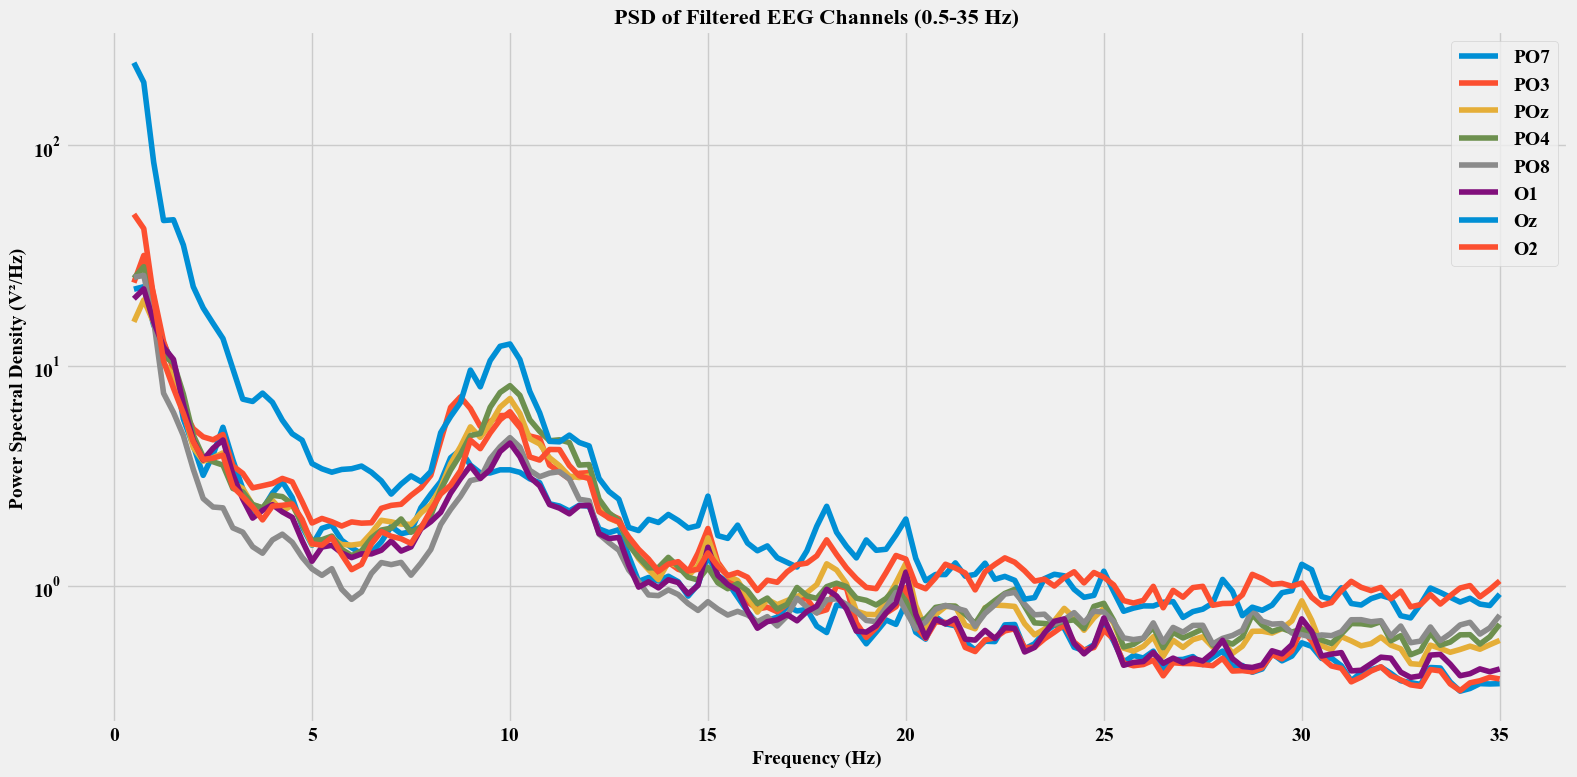

In [436]:
eegCleanedChannels = eegCleanedDFTime.iloc[:, 0:8] # From PO7 to O2

plt.figure(figsize=(16, 8))

plt.figure(figsize=(16, 8))

for ch in eegCleanedChannels:
    f, pxx = welch(eegCleanedDFTime[ch], fs=sampling_rate, nperseg=1024)
    
    # Apply frequency mask for 7–18 Hz
    freq_mask = (f >= 0.5) & (f <= 35)
    plt.semilogy(f[freq_mask], pxx[freq_mask], label=ch)

plt.title('PSD of Filtered EEG Channels (0.5-35 Hz)', fontname='Times New Roman', fontsize=16)
plt.xlabel('Frequency (Hz)', fontname='Times New Roman', fontsize=14)
plt.ylabel('Power Spectral Density (V²/Hz)', fontname='Times New Roman', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Filtering

In [437]:
def compute_snr(signal, fs, band=(0.5, 35)):
    f, pxx = welch(signal, fs=fs, nperseg=1024)
    band_mask = (f >= band[0]) & (f <= band[1])
    signalPower = np.sum(pxx[band_mask])
    noisePower = np.sum(pxx[~band_mask])
    snr = 10 * np.log10(signalPower / noisePower)
    return snr

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b,a, data)

In [438]:
# Fitler parameter
lowcut = 0.5
highcut = 35
snr_before = {}
snr_after = {}

for ch in eegChannels.columns:
    raw_signal = eegCleanedDFTime[ch].values

    # Before filtering
    snr_before[ch] = compute_snr(raw_signal, sampling_rate)

    # After filtering
    filtered_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, sampling_rate, 2)
    snr_after[ch] = compute_snr(filtered_signal, sampling_rate)

SNR Before Filtering:
PO7: 8.49 dB
PO3: 9.68 dB
POz: 8.09 dB
PO4: 7.72 dB
PO8: 6.11 dB
O1: 8.43 dB
Oz: 8.71 dB
O2: 5.90 dB

SNR After Filtering (7–18 Hz):
PO7: 18.12 dB
PO3: 19.25 dB
POz: 18.14 dB
PO4: 17.48 dB
PO8: 15.84 dB
O1: 18.14 dB
Oz: 16.38 dB
O2: 15.36 dB


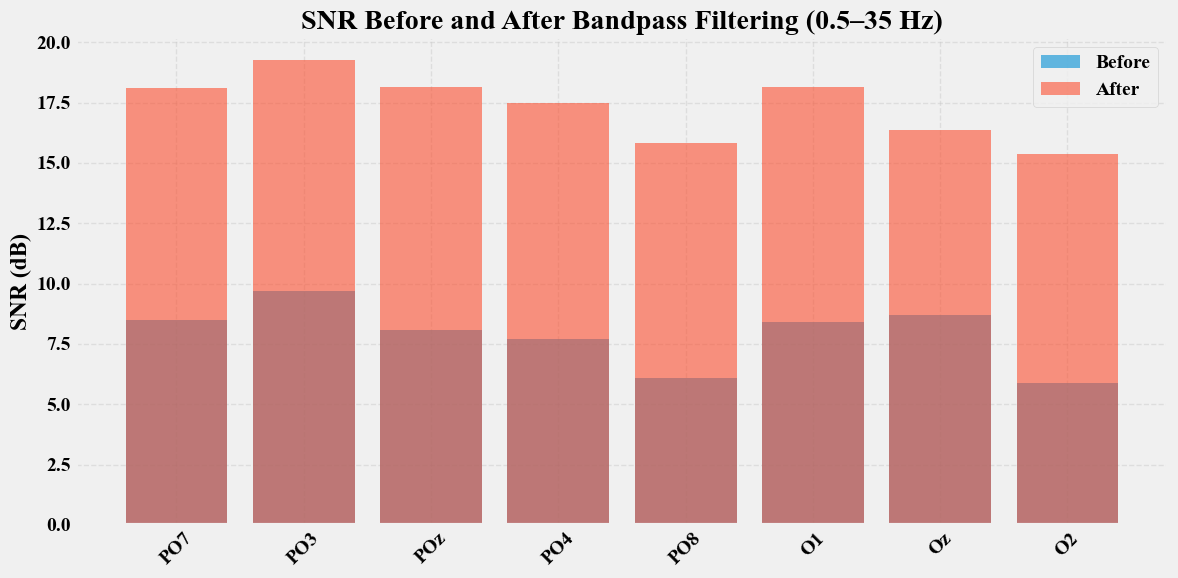

In [439]:
# Print SNR values
print("SNR Before Filtering:")
for ch in eegChannels.columns:
    print(f"{ch}: {snr_before[ch]:.2f} dB")

print("\nSNR After Filtering (7–18 Hz):")
for ch in eegChannels.columns:
    print(f"{ch}: {snr_after[ch]:.2f} dB")

# Plot
plt.figure(figsize=(12, 6))
channels = eegChannels.columns
plt.bar(channels, [snr_before[ch] for ch in channels], alpha=0.6, label='Before')
plt.bar(channels, [snr_after[ch] for ch in channels], alpha=0.6, label='After')
plt.ylabel('SNR (dB)')
plt.title('SNR Before and After Bandpass Filtering (0.5–35 Hz)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [440]:
# Data Frame for filtered signals
eegFiltered = pd.DataFrame(index=eegCleanedDFTime.index)

for ch in eegChannels.columns:
    filtered_signal = butter_bandpass_filter(eegCleanedDFTime[ch].values, lowcut, highcut, sampling_rate, order=2)
    eegFiltered[ch] = filtered_signal

eegFiltered['Trigger'] = eegCleanedDFTime['Trigger']

array([[<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>],
       [<Axes: xlabel='Time'>]], dtype=object)

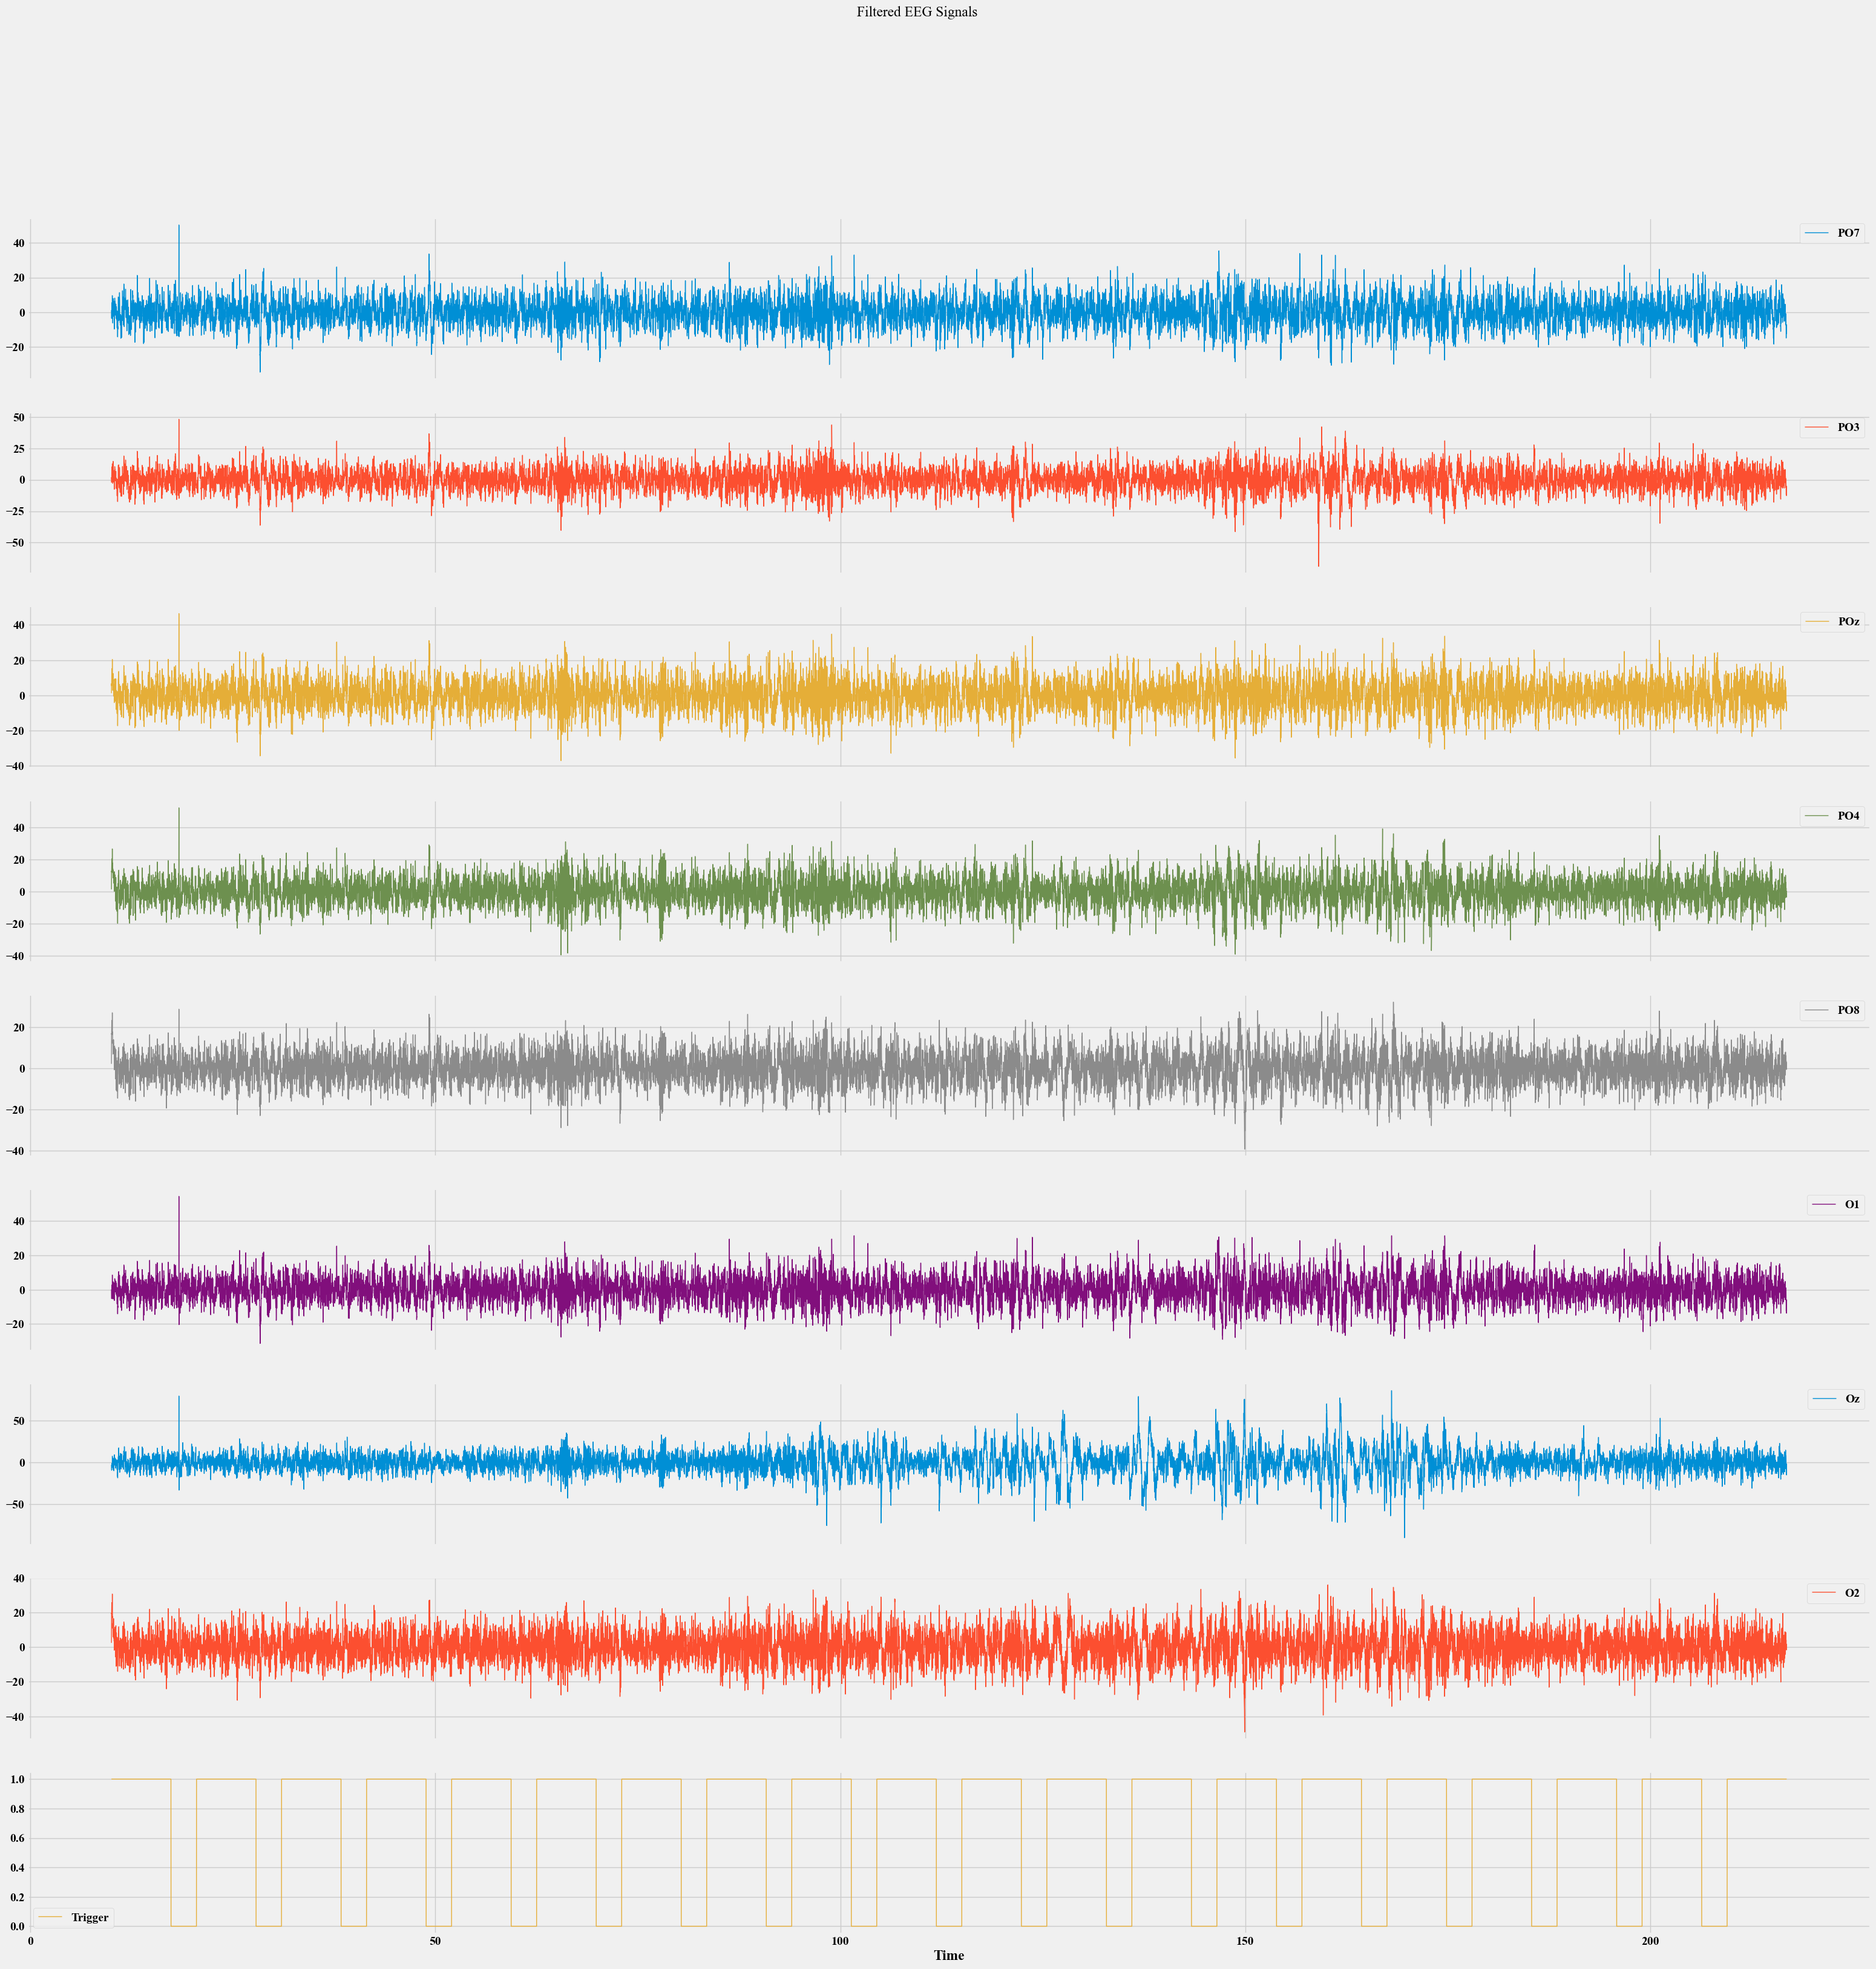

In [441]:
eegFiltered.plot(subplots = True,
           layout=(9,1),
           figsize =(35, 35),
           fontsize = 14,
           linewidth = 1,
           sharex = True,
           title = 'Filtered EEG Signals')

# Feature Extraction

In [364]:
from scipy.signal import stft
import time

'''# Configuration for plotting
plt.rcParams.update({
    "font.size": 10,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold"
})

# STFT Parameters
window_length = 1.0  # seconds
step_size = 0.5  # seconds
nperseg = int(window_length * sampling_rate)
step_size_samples = int(step_size * sampling_rate)

# Channel names and time
channels = eegFiltered.iloc[:, :-1].columns
timeSTFT = eegFiltered.iloc[:, :-1].index / sampling_rate

# Output directory setup
output_dir1 = fr'C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\STFT\subject_{subjectNum}'
output_subDir1 = fr'training_{trainingNum}'
directory1 = os.path.join(output_dir1, output_subDir1)
os.makedirs(directory1, exist_ok=True)

# Data and timing setup
eeg = eegFiltered.iloc[:, :]
stft_time = []

# Generate STFT spectrograms
for idx, channel in enumerate(channels):
    fig, ax = plt.subplots(figsize=(10, 8))  # Larger figure for better clarity
    signal = eeg[channel].values

    stft_start_time = time.time()

    # Compute STFT
    f, t, Zxx = stft(signal, fs=sampling_rate, nperseg=nperseg)
    Zxx_magnitude = np.abs(Zxx)

    # Plot STFT spectrogram
    cax = ax.pcolormesh(t, f, Zxx_magnitude, shading='gouraud', cmap='viridis', antialiased=True)

    # Highlight SSVEP target frequencies
    target_freqs = [15, 12, 10, 9]
    for freq in target_freqs:
        ax.axhline(y=freq, color='red', linestyle='--', linewidth=1.2, alpha=0.7)
        ax.text(t[-1]+0.1, freq, f'{freq} Hz', color='red', fontsize=9, va='center')

    # Formatting
    ax.set_title(f'{channel} - SSVEP Time-Frequency')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')
    ax.set_ylim(0.5, 30)  # Narrow range to focus on SSVEP

    # Color bar
    cb = plt.colorbar(cax, ax=ax)
    cb.set_label('Power', rotation=270, labelpad=15)
    cb.ax.tick_params(labelsize=10)

    # Save high-resolution image
    fig.tight_layout()
    output_file = os.path.join(directory1, f'{channel}_STFT.png')
    plt.savefig(output_file, dpi=600, bbox_inches='tight')  # High DPI

    stft_end_time = time.time()
    stft_time.append(stft_end_time - stft_start_time)

    # Clean up memory
    plt.close(fig)

# Average STFT generation time per channel
avg_time_ms = sum(stft_time) * 1000 / len(channels)
print(f'Average Short Time Fourier Transform Time: {avg_time_ms:.2f} ms')'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 537-538: truncated \UXXXXXXXX escape (3327501841.py, line 77)

In [442]:
def segment_trials_df(df, trigger_column, expected_trials=20):
    trigger = df[trigger_column].values
    threshold = 0.5
    above_thresh = trigger > threshold
    trigger_diff = np.diff(above_thresh.astype(int), prepend=above_thresh[0].astype(int))
    
    # Detect rising and falling edges
    start_idxs = np.where(trigger_diff == 1)[0]
    end_idxs = np.where(trigger_diff == -1)[0]

    # Fix cut edges
    if len(start_idxs) > 0 and len(end_idxs) > 0:
        if start_idxs[0] > end_idxs[0]:  # if first rising edge is missing
            start_idxs = np.insert(start_idxs, 0, 0)
        if start_idxs[-1] > end_idxs[-1]:  # if last falling edge is missing
            end_idxs = np.append(end_idxs, len(trigger) - 1)
    
    # Make sure we have equal pairs
    min_len = min(len(start_idxs), len(end_idxs))
    start_idxs = start_idxs[:min_len]
    end_idxs = end_idxs[:min_len]

    trials = []
    for start, end in zip(start_idxs, end_idxs):
        trial_df = df.iloc[start:end+1, :-1]  # Exclude trigger column
        trials.append(trial_df)

    # Ensure exactly expected_trials are returned
    if len(trials) > expected_trials:
        trials = trials[:expected_trials]
    elif len(trials) < expected_trials:
        print(f"Warning: Only {len(trials)} trials found, expected {expected_trials}. Padding with empty trials.")
        empty_trial = pd.DataFrame(np.zeros_like(trials[0].values), columns=trials[0].columns)
        while len(trials) < expected_trials:
            trials.append(empty_trial.copy())

    print(f"Number of trials: {len(trials)}")
    return trials

In [443]:
def extract_wavelet_features(trial_df, wavelet='db4', level=2):
    features = {}
    
    for col in trial_df.columns:
        # Decompose the signal into wavelet coefficients
        coeffs = pywt.wavedec(trial_df[col].values, wavelet, level=level)
        
        for i, coeff in enumerate(coeffs):
            # Basic features: mean and standard deviation
            features[f'{col}_mean_L{i}'] = np.mean(coeff)
            features[f'{col}_std_L{i}'] = np.std(coeff)
            
            # Additional features:
            features[f'{col}_energy_L{i}'] = np.sum(coeff**2)  # Energy
            features[f'{col}_skew_L{i}'] = skew(coeff)  # Skewness
            features[f'{col}_kurtosis_L{i}'] = kurtosis(coeff)  # Kurtosis
            features[f'{col}_max_L{i}'] = np.max(coeff)  # Max
            features[f'{col}_min_L{i}'] = np.min(coeff)  # Min
            features[f'{col}_rms_L{i}'] = np.sqrt(np.mean(coeff**2))  # RMS

    return features


In [444]:
def create_wavelet_dataset_df(trials, labels):
    all_features = []
    for i, trial in enumerate(trials):
        feat = extract_wavelet_features(trial)
        # create 4 binary columns for labels
        label_row = {str(cls): int(labels[i] == cls) for cls in [15, 12, 10, 9]}
        feat.update(label_row)
        all_features.append(feat)
    df = pd.DataFrame(all_features)
    return df

In [445]:
# Segment EEG into trials
trials = segment_trials_df(eegFiltered, trigger_column=eegFiltered.columns[-1])

# Correct label pattern: repeat [15, 12, 10, 9] five times
labels = [15, 12, 10, 9] * 5  # total 20 trials

all_features = []

for i, (trial_df, label) in enumerate(zip(trials, labels)):
    print(f"Processing trial {i+1}/{len(trials)} with label {label}")
    features = {}

    # Extract wavelet features per channel
    for ch in trial_df.columns:
        coeffs = pywt.wavedec(trial_df[ch], 'db4', level=2)
        for j, c in enumerate(coeffs):
            features[f'{ch}_c{j}_mean'] = np.mean(c)
            features[f'{ch}_c{j}_std'] = np.std(c)

    # Add one-hot label in desired order
    for cls in [15, 12, 10, 9]:
        features[str(cls)] = int(label == cls)

    all_features.append(features)

# Create DataFrame
eegFeaturesDF = pd.DataFrame(all_features)

# Reorder columns: features first, then labels
label_cols = ['15', '12', '10', '9']
feature_cols = [col for col in eegFeaturesDF.columns if col not in label_cols]
eegFeaturesDF = eegFeaturesDF[feature_cols + label_cols]

# Final output
print("Final DataFrame shape:", eegFeaturesDF.shape)
print(eegFeaturesDF.head())

Number of trials: 20
Processing trial 1/20 with label 15
Processing trial 2/20 with label 12
Processing trial 3/20 with label 10
Processing trial 4/20 with label 9
Processing trial 5/20 with label 15
Processing trial 6/20 with label 12
Processing trial 7/20 with label 10
Processing trial 8/20 with label 9
Processing trial 9/20 with label 15
Processing trial 10/20 with label 12
Processing trial 11/20 with label 10
Processing trial 12/20 with label 9
Processing trial 13/20 with label 15
Processing trial 14/20 with label 12
Processing trial 15/20 with label 10
Processing trial 16/20 with label 9
Processing trial 17/20 with label 15
Processing trial 18/20 with label 12
Processing trial 19/20 with label 10
Processing trial 20/20 with label 9
Final DataFrame shape: (20, 52)
   PO7_c0_mean  PO7_c0_std  PO7_c1_mean  PO7_c1_std  PO7_c2_mean  PO7_c2_std  \
0     0.187364   11.592218    -0.006244    2.029257    -0.000191    0.245668   
1     0.291052   12.478483    -0.001863    2.179576    -0.000

In [446]:
def extract_psd_features(trial_df, fs):
    freq_bands = {
        f'f{int(f)}': (f - 0.5, f + 0.5)
        for f in np.arange(8.5, 30.5 + 1, 1)  # from 8.5 to 30.5 Hz inclusive
    }

    psd_features = {}
    for ch in trial_df.columns:
        signal = trial_df[ch].values
        nperseg = min(fs, len(signal))  # ensure nperseg is appropriate
        freqs, psd = welch(signal, fs=fs, nperseg=nperseg)

        for band_name, (low, high) in freq_bands.items():
            idx = np.logical_and(freqs >= low, freqs <= high)
            band_power = np.mean(psd[idx]) if np.any(idx) else 0.0
            psd_features[f'{ch}_{band_name}_power'] = band_power

    return psd_features

In [447]:
psd_features_all = []
labels = [15, 12, 10, 9] * 5  # total 20 trials, same pattern

for i, (trial, label) in enumerate(zip(trials, labels)):
    print(f"Processing trial {i+1}/20 for PSD features...")
    psd_feat = extract_psd_features(trial, fs=sampling_rate)
    
    # Add one-hot label
    for cls in [15, 12, 10, 9]:
        psd_feat[str(cls)] = int(label == cls)
    
    psd_features_all.append(psd_feat)

eegpsdFeaturesDF = pd.DataFrame(psd_features_all)

# Ensure label columns are last
label_cols = ['15', '12', '10', '9']
feature_cols = [col for col in eegpsdFeaturesDF.columns if col not in label_cols]
eegpsdFeaturesDF = eegpsdFeaturesDF[feature_cols + label_cols]

print("PSD feature DataFrame shape:", eegpsdFeaturesDF.shape)
print(eegpsdFeaturesDF)

Processing trial 1/20 for PSD features...
Processing trial 2/20 for PSD features...
Processing trial 3/20 for PSD features...
Processing trial 4/20 for PSD features...
Processing trial 5/20 for PSD features...
Processing trial 6/20 for PSD features...
Processing trial 7/20 for PSD features...
Processing trial 8/20 for PSD features...
Processing trial 9/20 for PSD features...
Processing trial 10/20 for PSD features...
Processing trial 11/20 for PSD features...
Processing trial 12/20 for PSD features...
Processing trial 13/20 for PSD features...
Processing trial 14/20 for PSD features...
Processing trial 15/20 for PSD features...
Processing trial 16/20 for PSD features...
Processing trial 17/20 for PSD features...
Processing trial 18/20 for PSD features...
Processing trial 19/20 for PSD features...
Processing trial 20/20 for PSD features...
PSD feature DataFrame shape: (20, 188)
    PO7_f8_power  PO7_f9_power  PO7_f10_power  PO7_f11_power  PO7_f12_power  \
0       1.257421      1.254583 

In [448]:
features_DF = pd.DataFrame()
df_list = [eegFeaturesDF, eegpsdFeaturesDF]

features_DF = pd.concat(df_list, axis = 1)

features_DF_all = pd.concat([features_DF_all, features_DF], axis=0, ignore_index=True)

In [449]:
print(features_DF_all)

    PO7_c0_mean  PO7_c0_std  PO7_c1_mean  PO7_c1_std  PO7_c2_mean  PO7_c2_std  \
0     -0.016869    7.537960     0.004561    1.433821    -0.000112    0.165203   
1      0.122903    8.056180     0.006111    1.336026    -0.000068    0.153160   
2      0.102658    6.859746    -0.003237    1.149438    -0.000068    0.125009   
3      0.070727    8.882513     0.005524    1.474295    -0.000008    0.166475   
4      0.254699    8.646438    -0.007725    1.275317    -0.000070    0.158416   
..          ...         ...          ...         ...          ...         ...   
75     0.112080   17.974364     0.006501    2.348621     0.000160    0.299720   
76     0.047129   13.106681    -0.020146    2.523479     0.000030    0.296219   
77     0.037858   11.686273    -0.001034    2.348995     0.000418    0.290566   
78    -0.049208   13.921331     0.008005    2.338275    -0.000240    0.295608   
79     0.080270   13.363107    -0.003283    2.224702    -0.000056    0.286973   

    PO3_c0_mean  PO3_c0_std

In [450]:
features_DF_all.to_csv(r"C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\Code\EEGFeaturesHarmonics.csv", index=False)

# Classification

In [326]:
df = pd.read_csv(r'C:\Users\PC\Desktop\Second Semester 2025-2026\BCI Spring School Hackathon 2025\Code\EEGFeatures.csv')

Epoch 1/1500


c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1354 - loss: 1.6317
Epoch 2/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7708 - loss: 0.8785 
Epoch 3/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.5326
Epoch 4/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.2307
Epoch 5/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1004
Epoch 6/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0208
Epoch 7/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0066
Epoch 8/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 9/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 10/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 3.4543e-04
Epoch 11/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 2.4309e-04
Epoch 12/1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0

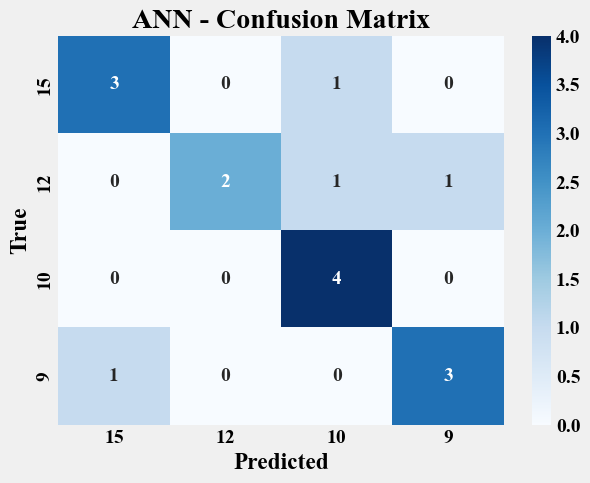


Classification Report:
              precision    recall  f1-score   support

          15       0.75      0.75      0.75         4
          12       1.00      0.50      0.67         4
          10       0.67      1.00      0.80         4
           9       0.75      0.75      0.75         4

    accuracy                           0.75        16
   macro avg       0.79      0.75      0.74        16
weighted avg       0.79      0.75      0.74        16



In [486]:
X = df.iloc[:, 0:84].values
y = df.iloc[:, 84:88].values  # Already one-hot

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1))

# 3. Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Build ANN model
model = Sequential([
    Dense(1180, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(944, activation='relu'),
    Dense(708, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes: 15, 12, 10, 9
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Train the model
history = model.fit(
    X_train, y_train,
    epochs=1500,
    batch_size=32,
    verbose=1
)
# 6. Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n ANN Accuracy on test set: {acc:.2f}")

# 7. Confusion matrix
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[15,12,10,9], yticklabels=[15,12,10,9])
plt.title("ANN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 8. Classification report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['15', '12', '10', '9']))

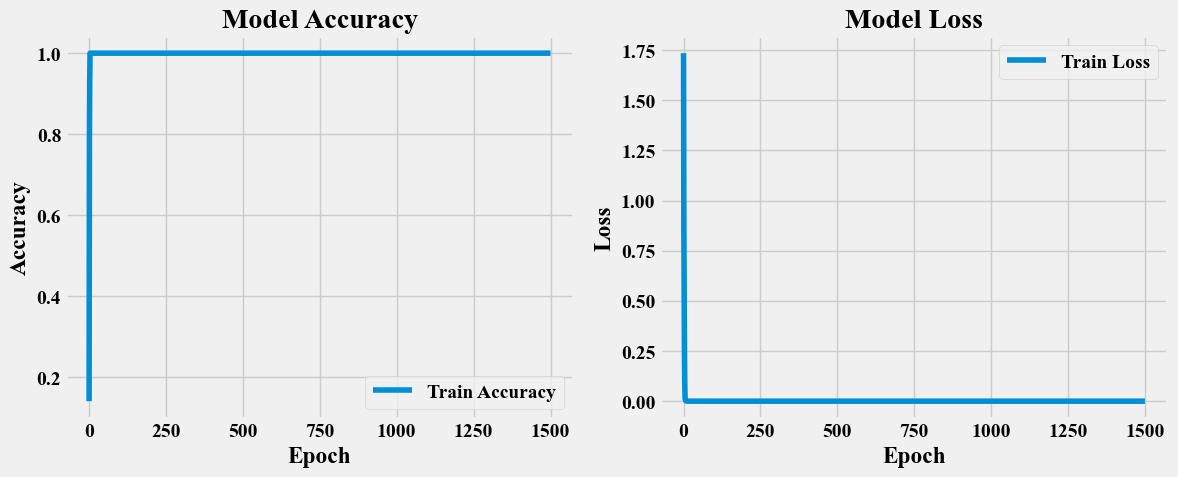

In [488]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [485]:
X = df.iloc[:, 0:84].values
y = df.iloc[:, 84:88].values  # Already one-hot
#X = features_DF_all.iloc[:, 0:236].values
#y = features_DF_all.iloc[:, 236:240].values  # Already one-hot
y_indices = np.argmax(y, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_indices, test_size=0.2, random_state=42, stratify=y.argmax(axis=1))

# 3. Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        solver='lbfgs', 
        C=1.0, 
        multi_class='multinomial', 
        random_state=42
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=None, 
        min_samples_split=2, 
        random_state=42
    ),
    
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=3, 
        random_state=42
    ),
    
    'SVM': SVC(
        C=3.0, 
        kernel='rbf', 
        gamma='scale', 
        probability=True, 
        random_state=42
    ),
    
    'KNN': KNeighborsClassifier(
        n_neighbors=5, 
        metric='minkowski', 
        p=2  # Euclidean distance
    )
}

# Train and evaluate
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')

Logistic Regression Accuracy: 1.0000
Random Forest Accuracy: 1.0000
Gradient Boosting Accuracy: 1.0000
SVM Accuracy: 0.6875
KNN Accuracy: 0.4375
